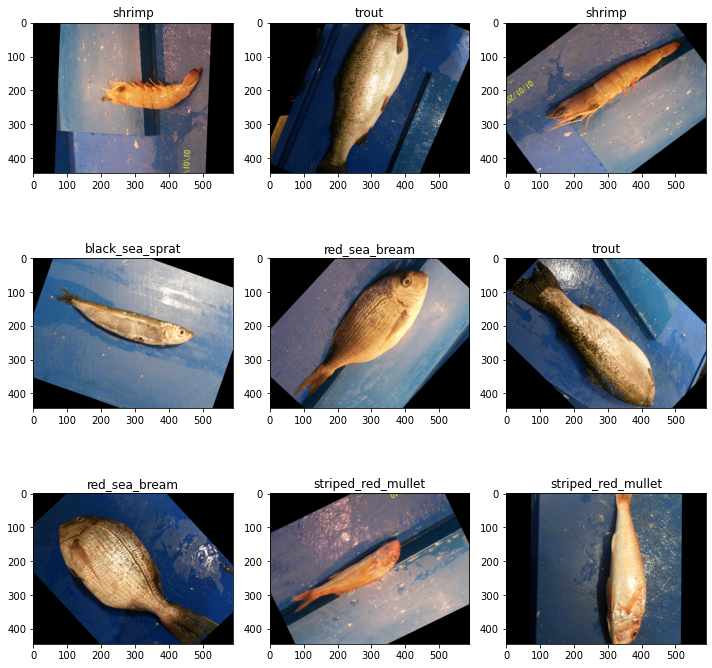

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


dataset_folder = '/Users/anmol_gorakshakar/python/machine_learning/fish_dataset/archive/Fish_Dataset/Fish_Dataset'
if os.path.exists(dataset_folder):
    fish_folders = [f"{dataset_folder}/{i}/{i}" for i in os.listdir(dataset_folder) if '.' not in i]
    holder = []
    for folder in fish_folders:
        label = folder.split('/')[-1].lower().replace('-', '_').replace(' ', '_')
        photos = pd.DataFrame([f"{folder}/{i}" for i in os.listdir(folder) if '.png' in i], columns=['path'])
        photos['label'] = label
        holder.append(photos)
    photos = pd.concat(holder).reset_index(drop=True)

fig, ax = plt.subplots(3,3, figsize=(10,10))
files = photos.sample(n=9)
for i, a in enumerate(ax.flat):
    sample_img = photos.sample()
    sample_pixels = sample_img.path.values[0]
    picture = plt.imread(sample_pixels)
    a.imshow(picture)
    a.set_title(sample_img.label.values[0])
plt.tight_layout()
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(photos, test_size=0.1, random_state=12, stratify=photos['label'])
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=12, stratify=X_train['label'])

In [3]:
batch_size=32
image_size=(224,224)

In [4]:
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

In [5]:
# image preprocessing
img_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                          x_col='path',
                                          y_col='label',
                                          target_size=image_size,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=batch_size,
                                          seed=42)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                          x_col='path',
                                          y_col='label',
                                          target_size=image_size,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=batch_size,
                                          seed=42)

X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='path',
                                          y_col='label',
                                          target_size=image_size,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=batch_size,
                                          seed=42)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [7]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()
# scale image values to 0..1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

# 1. Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 2. Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 3. Conv2D layer
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# scale to 1 dimensional input for NN
model.add(Flatten())

# hidden fully connected layer
model.add(Dense(256))
model.add(Activation('relu'))

# inhibit overfitting
model.add(Dropout(0.2))

# output fully connected layer
model.add(Dense(9))
model.add(Activation('softmax'))

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
# stop training when accuracy has stopped improving 
cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# train model 
hst = model.fit(X_train, validation_data=X_val, epochs=10, callbacks=cb)

Epoch 1/10
203/203 [==============================] - 201s 987ms/step - loss: 1.6162 - accuracy: 0.4661 - val_loss: 0.2639 - val_accuracy: 0.9080
Epoch 2/10
203/203 [==============================] - 197s 972ms/step - loss: 0.2329 - accuracy: 0.9258 - val_loss: 0.1606 - val_accuracy: 0.9438
Epoch 3/10
203/203 [==============================] - 193s 951ms/step - loss: 0.0812 - accuracy: 0.9718 - val_loss: 0.0646 - val_accuracy: 0.9802
Epoch 4/10
203/203 [==============================] - 198s 976ms/step - loss: 0.0461 - accuracy: 0.9847 - val_loss: 0.0481 - val_accuracy: 0.9802
Epoch 5/10
203/203 [==============================] - 201s 990ms/step - loss: 0.0207 - accuracy: 0.9938 - val_loss: 0.0605 - val_accuracy: 0.9741
Epoch 6/10
203/203 [==============================] - 198s 975ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.0583 - val_accuracy: 0.9790
Epoch 7/10
203/203 [==============================] - 195s 959ms/step - loss: 0.0247 - accuracy: 0.9920 - val_loss: 0.0453 -

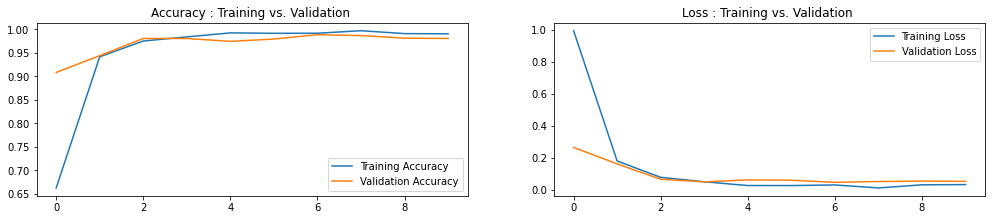

In [9]:
accuracy = hst.history['accuracy']
loss = hst.history['loss']
val_loss = hst.history['val_loss']
val_accuracy = hst.history['val_accuracy']

plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training vs. Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.title('Loss : Training vs. Validation ')
plt.legend(loc='upper right')
plt.show()

In [10]:
res = model.evaluate(X_test)

29/29 [==============================] - 9s 305ms/step - loss: 0.0668 - accuracy: 0.9811


In [11]:
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')

Train Accuracy: 99.01
Val Accuracy: 98.02
Test Accuracy: 98.11


# How does convolution work

## What is convolution?
- Method of passing a filter or kernel (matrix of size x*y, usually x*x) over a an image or other larger matrix and the result is captured in a smaller matrix.
- Convolution is good for abstraction of information from given data
- different kernels can abstract different kind of information

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

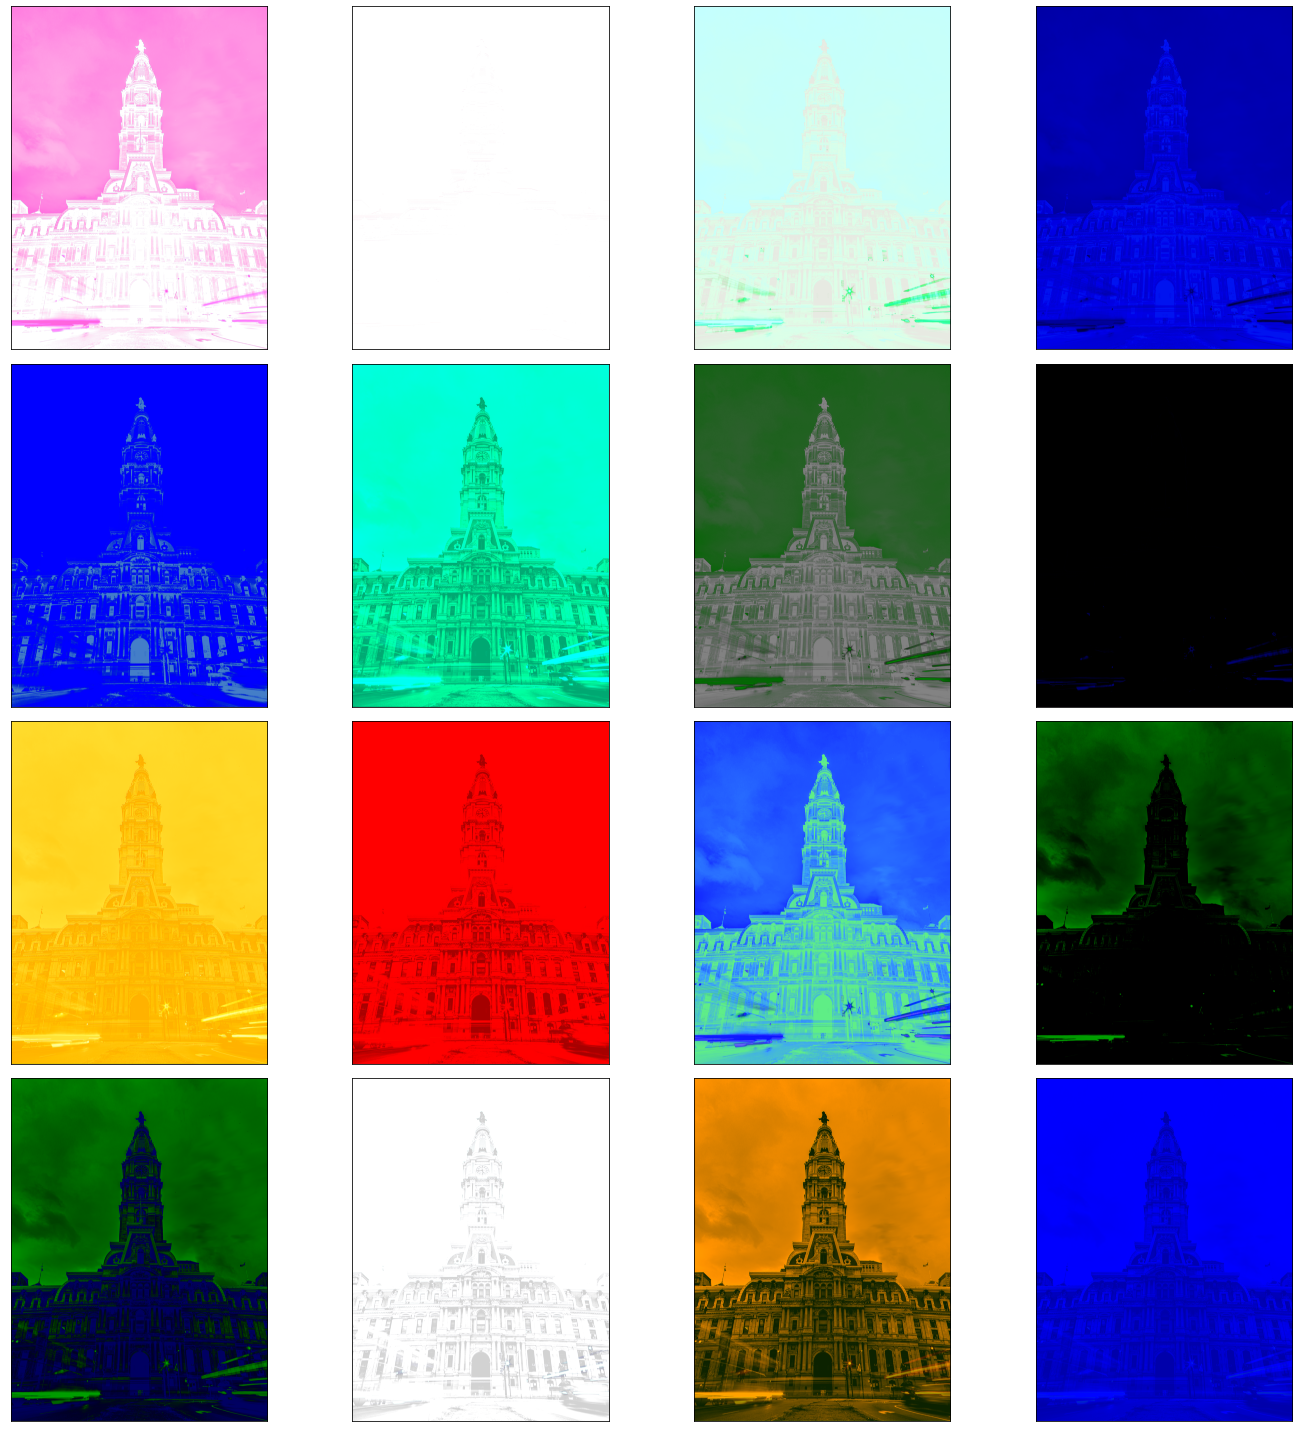

In [184]:
from random import choice
fig, ax = plt.subplots(4,4, figsize=(20,20))
img = np.array([plt.imread('/Users/anmol_gorakshakar/Documents/cityhall_composite.png')])
for i, a in enumerate(ax.flat):
    convd = tf.keras.layers.Conv2D(filters=choice([3,4]), 
                           kernel_size=choice([(2,2), (3,3), (4,4)]), 
                           padding='same', 
                           activation='relu',
                           input_shape=img.shape[1:])(img)
    a.imshow(convd[0])
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

# What is Activation Layer
- 

In [199]:
X_test.next()

(array([[[[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
 
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
 
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ]],
 
         ...,
 
         [[-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          [-103.939, -116.779, -123.68 ],
          ...,
          [-103.939, -116.779, -1